# K-Means Clustering — From Scratch

This Colab demonstrates K-Means implemented from scratch (vectorized NumPy), evaluation (elbow, silhouette), comparison against scikit-learn, visualizations, and saving model artifacts. Follow cells in order and run each cell in Colab.

# Install / Environment notes
# (Uncomment the pip install line when running in Colab if packages are missing)

# !pip install scikit-learn matplotlib seaborn joblib umap-learn

print('Run in Colab: enable GPU if you will use heavy datasets, but K-Means runs on CPU fine.')

In [6]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans as SKKMeans
import joblib

sns.set(style='whitegrid')

print('Libraries imported')

Libraries imported


In [7]:
# Utility functions: pairwise distances and kmeans++ init

def pairwise_distances(a, b):
    """Compute squared Euclidean distances between rows of a and rows of b."""
    # a: (n, d), b: (m, d) -> returns (n, m)
    return np.sum((a[:, None, :] - b[None, :, :])**2, axis=2)


def kmeans_plus_plus_init(X, k, random_state=None):
    # Accept either an int seed or an existing RandomState
    if isinstance(random_state, np.random.RandomState):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)
    n_samples, _ = X.shape
    centers = np.empty((k, X.shape[1]), dtype=X.dtype)
    # choose first center uniformly
    idx = rng.randint(0, n_samples)
    centers[0] = X[idx]
    # distances to closest center
    closest_dist_sq = pairwise_distances(X, centers[0:1]).reshape(-1)
    for c in range(1, k):
        probs = closest_dist_sq / closest_dist_sq.sum()
        idx = rng.choice(n_samples, p=probs)
        centers[c] = X[idx]
        new_dist_sq = pairwise_distances(X, centers[c:c+1]).reshape(-1)
        closest_dist_sq = np.minimum(closest_dist_sq, new_dist_sq)
    return centers

print('Utility functions defined')

Utility functions defined


In [8]:
# K-Means implementation (vectorized NumPy)

def kmeans_numpy(X, k, init='kmeans++', max_iter=300, tol=1e-4, random_state=None):
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X.shape
    if init == 'random':
        centers = X[rng.choice(n_samples, k, replace=False)]
    elif init == 'kmeans++':
        centers = kmeans_plus_plus_init(X, k, random_state=rng)
    else:
        raise ValueError('Unknown init')

    labels = np.zeros(n_samples, dtype=int)
    inertias = []
    for it in range(max_iter):
        # assignment
        dists = pairwise_distances(X, centers)  # squared distances
        new_labels = np.argmin(dists, axis=1)
        # compute inertia
        inertia = np.sum(np.min(dists, axis=1))
        inertias.append(inertia)
        # update
        new_centers = np.zeros_like(centers)
        for j in range(k):
            members = X[new_labels == j]
            if len(members) == 0:
                # reinitialize empty cluster to a random point
                new_centers[j] = X[rng.randint(0, n_samples)]
            else:
                new_centers[j] = members.mean(axis=0)
        center_shift = np.sqrt(np.sum((centers - new_centers)**2, axis=1)).max()
        centers = new_centers
        labels = new_labels
        if center_shift <= tol:
            break
    return centers, labels, inertias

print('K-Means function implemented')

K-Means function implemented


In [9]:
# Demo: synthetic blobs + Iris dataset

# synthetic
X_blob, y_blob = make_blobs(n_samples=500, centers=4, cluster_std=0.60, random_state=42)
scaler = StandardScaler()
X_blob_s = scaler.fit_transform(X_blob)

# Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
X_iris_s = scaler.fit_transform(X_iris)

print('Datasets ready')

Datasets ready


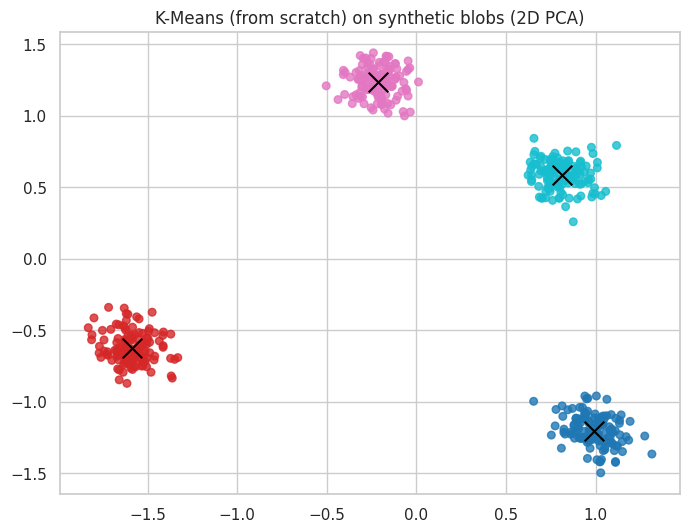

Final inertia: 10.602257105672482


In [10]:
# Run K-Means on synthetic data and visualize
k = 4
centers, labels, inertias = kmeans_numpy(X_blob_s, k=k, init='kmeans++', random_state=42)

# 2D projection for plotting
pca = PCA(n_components=2)
proj = pca.fit_transform(X_blob_s)
centers_proj = pca.transform(centers)

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], c=labels, cmap='tab10', s=30, alpha=0.8)
plt.scatter(centers_proj[:,0], centers_proj[:,1], c='black', s=200, marker='x')
plt.title('K-Means (from scratch) on synthetic blobs (2D PCA)')
plt.show()

print('Final inertia:', inertias[-1])

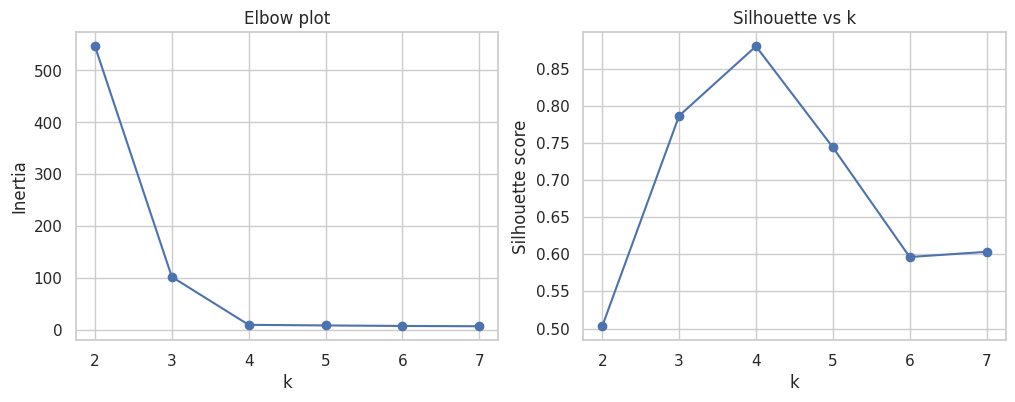

In [11]:
# Elbow plot and silhouette for a range of k
ks = range(2,8)
inertias_list = []
sil_scores = []
for kk in ks:
    _, lab, inert = kmeans_numpy(X_blob_s, k=kk, init='kmeans++', random_state=42)
    inertias_list.append(inert[-1])
    if kk <= len(X_blob_s)-1:
        try:
            sil = silhouette_score(X_blob_s, lab)
        except Exception:
            sil = np.nan
        sil_scores.append(sil)
    else:
        sil_scores.append(np.nan)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(ks), inertias_list, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow plot')

plt.subplot(1,2,2)
plt.plot(list(ks), sil_scores, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette vs k')
plt.show()

In [12]:
# Compare with scikit-learn KMeans and runtime
import time

start = time.time()
sk_km = SKKMeans(n_clusters=4, init='k-means++', random_state=42).fit(X_blob_s)
end = time.time()
print('sklearn KMeans inertia:', sk_km.inertia_, ' time:', end-start)

# Compare labels via ARI (if available)
from sklearn.metrics import adjusted_rand_score
print('Adjusted Rand Index between from-scratch and sklearn:', adjusted_rand_score(labels, sk_km.labels_))


sklearn KMeans inertia: 10.602257105672479  time: 0.08825540542602539
Adjusted Rand Index between from-scratch and sklearn: 1.0


In [13]:
# Save centroids and labels
joblib.dump({'centers': centers, 'labels': labels}, 'kmeans_from_scratch_blob.pkl')
print('Saved kmeans_from_scratch_blob.pkl')

Saved kmeans_from_scratch_blob.pkl
